In [1]:
import networkx as nx
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import re

from API import K
import requests
import json
import googlemaps
from dms2dec.dms_convert import dms2dec
import geopy.distance
pd.options.mode.chained_assignment = None  # default='warn'

## Import network and IVS data

In [2]:
# import network
G = pickle.load(open('data/network_digital_twin_v0.3.pickle', 'rb'))

# import cleaned and restructured IVS data
df_ivs = pickle.load( open("data/df_trips_per_path_hourly.p", "rb" ) )

df_h = pd.read_csv('data/cleaned_harbours.csv')
# extract position for drawing purposes
pos_dict = {}
for node in G.nodes:
    pos_dict[node] = (G.nodes[node]['X'],G.nodes[node]['Y'])

#extract data
df_links = nx.to_pandas_edgelist(G)
df_nodes = pd.DataFrame.from_dict(dict(G.nodes(data=True)), orient='index')

# add degree to dataframes
df_links['degree_source'] = df_links.source.apply(lambda x: G.degree[x])
df_links['degree_target'] = df_links.source.apply(lambda x: G.degree[x])
df_nodes['degree'] = G.degree
df_nodes['degree'] = df_nodes.degree.apply(lambda x: x[1])

In [3]:
df_links.loc[df_links.source.str.contains('Berth')]

,source,target,Description,geometry,subgraph,WidePushedWidth,GeoType,GeneralLength,EndJunctionId,Length,...,PushedLength,WidePushedDepth,GeneralWidth,PushedDepth,StartJunctionId,SeaFairingHeight,SeaFairingDepth,GeneralHeight,degree_source,degree_target
15985,Berth1,Berth2,"Rijn - Hernekanaalschip, Eenbaksduwstel","{'type': 'LineString', 'coordinates': ((4.9658...",0,NaN,section,100.0,Berth2,0.944,...,NaN,NaN,11.4,NaN,Berth1,NaN,NaN,NaN,2,2
15986,Berth2,22638160,"Rijn - Hernekanaalschip, Eenbaksduwstel","{'type': 'LineString', 'coordinates': ((4.9643...",0,NaN,section,100.0,22638160,0.944,...,NaN,NaN,11.4,NaN,Berth2,NaN,NaN,NaN,2,2
15989,Berth4,Berth5,"Groot Rijnschip, Eenbaksduwstel","{'type': 'LineString', 'coordinates': ((4.6177...",0,NaN,section,NaN,Berth5,1.021,...,NaN,NaN,NaN,NaN,Berth4,NaN,NaN,NaN,2,2
15990,Berth5,Berth6,"Groot Rijnschip, Eenbaksduwstel","{'type': 'LineString', 'coordinates': ((4.6150...",0,NaN,section,NaN,Berth6,1.021,...,NaN,NaN,NaN,NaN,Berth5,NaN,NaN,NaN,2,2
15991,Berth6,Berth7,"Groot Rijnschip, Eenbaksduwstel","{'type': 'LineString', 'coordinates': ((4.6141...",0,NaN,section,NaN,Berth7,1.021,...,NaN,NaN,NaN,NaN,Berth6,NaN,NaN,NaN,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16159,Berth300,Berth301,NaN,"{'type': 'LineString', 'coordinates': ((5.2251...",0,NaN,section,NaN,Berth301,1.000,...,NaN,NaN,NaN,NaN,Berth300,NaN,NaN,NaN,2,2
16160,Berth301,Berth302,NaN,"{'type': 'LineString', 'coordinates': ((5.2237...",0,NaN,section,NaN,Berth302,1.000,...,NaN,NaN,NaN,NaN,Berth301,NaN,NaN,NaN,2,2
16161,Berth302,Berth303,NaN,"{'type': 'LineString', 'coordinates': ((5.2224...",0,NaN,section,NaN,Berth303,1.000,...,NaN,NaN,NaN,NaN,Berth302,NaN,NaN,NaN,2,2
16162,Berth303,8865499,NaN,"{'type': 'LineString', 'coordinates': ((5.2210...",0,NaN,section,NaN,8865499,1.000,...,NaN,NaN,NaN,NaN,Berth303,NaN,NaN,NaN,2,2


In [4]:
df_nodes.loc[df_nodes.n.str.contains('Berth')]

,n,X,Y,geometry,Wkt,degree
Berth270,Berth270,6.634955,52.365359,"{'type': 'Point', 'coordinates': (6.6349554101...",POINT (6.6349554101093098 52.3653591143051003),1
Berth0,Berth0,5.362122,51.952032,"{'type': 'Point', 'coordinates': (5.3621223110...",POINT (5.3621223110347751 51.9520318707057740),2
Berth1,Berth1,4.965865,51.829624,"{'type': 'Point', 'coordinates': (4.9658647733...",POINT (4.9658647733010728 51.8296240933179959),2
Berth2,Berth2,4.964364,51.828428,"{'type': 'Point', 'coordinates': (4.9643639493...",POINT (4.9643639493799014 51.8284282742138416),2
Berth3,Berth3,4.963793,51.827971,"{'type': 'Point', 'coordinates': (4.9637926288...",POINT (4.9637926288426035 51.8279713846904571),2
...,...,...,...,...,...,...
Berth300,Berth300,5.225147,51.816640,"{'type': 'Point', 'coordinates': (5.2251473773...",POINT (5.2251473773199510 51.8166404917617385),2
Berth301,Berth301,5.223776,51.816313,"{'type': 'Point', 'coordinates': (5.2237757194...",POINT (5.2237757194631174 51.8163127103276935),2
Berth302,Berth302,5.222425,51.815990,"{'type': 'Point', 'coordinates': (5.2224246051...",POINT (5.2224246051149352 51.8159898381213324),2
Berth303,Berth303,5.221081,51.815669,"{'type': 'Point', 'coordinates': (5.2210806772...",POINT (5.2210806772796499 51.8156686832568596),2


In [5]:
# check dataframe
df_ivs

,origin,destination,trip_count,hour,M12,M8,BII-6b,M10,BIIa-1,M9,...,B03,C4,B04,C2l,BII-2L,B02,C1b,C2b,B01,C1l
0,NLRTM,NLAMS,323,0,91,109,0,18,2,45,...,0,0,0,0,1,0,0,0,0,0
1,NLRTM,NLAMS,302,1,78,110,0,17,3,55,...,0,0,0,0,0,0,0,0,0,0
2,NLRTM,NLAMS,275,2,52,122,0,10,3,46,...,0,1,0,0,0,0,0,0,0,0
3,NLRTM,NLAMS,303,3,52,117,0,9,4,52,...,0,1,0,0,0,0,0,0,0,0
4,NLRTM,NLAMS,367,4,55,144,0,14,1,72,...,0,0,2,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4795,NLVLI,NLVLA,1,19,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4796,NLVLI,NLVLA,5,20,0,5,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4797,NLVLI,NLVLA,4,21,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
4798,NLVLI,NLVLA,5,22,0,5,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
#check number of trips that we start with
df_ivs.trip_count.sum()

91187

## Step 1: Select relevant harbours and determine decimal degrees coordinates for all habours

In [7]:
# get unique harbours from IVS dataframe
h_list = list(set(list(df_ivs.origin.unique())) | set(list(df_ivs.destination.unique())))

# get unique city codes (e.g. remove NL prefix)
h_list = [re.sub("NL", "", i) for i in h_list]

#subset harbour data for these harbours and reset index
df_h = df_h.loc[(df_h.city_abbr.isin(h_list)) & (df_h.country == 'NL')]
df_h.reset_index(inplace=True, drop=True)

In [8]:
len(h_list)

100

Thus, the 200 most frequented routes are associated with 100 unique harbours

In [9]:
# fix dtypes
for i in df_h.columns:
    if df_h.dtypes[i] == 'O':
        df_h[i] = df_h[i].astype('|S80')
        df_h[i] = df_h[i].apply(lambda x: x.decode('utf-8'))
# the coordinates are inaccurate and quite a lot of data is missing. This must be fixed first before we continue.

In [10]:
# #convert latitude and longitude to decimal degrees for harbours with this entry
df_h['lat'] = 0
df_h['lon'] = 0
for key, coords in enumerate(df_h.coords):
    lat_lon=[]
    if coords!='nan':
        for j in range(2):
            if j == 0:
                part_a = coords.split()[j][:2]
                part_b = coords.split()[j][-3:-1]
                cor = (str(part_a)+"°"+str(part_b)+''''0"N"''')
                cor = dms2dec(cor)
                df_h.lat[key] = cor
            else:
                part_a = coords.split()[j][:3]
                part_b = coords.split()[j][-3:-1]
                cor = (str(part_a)+"°"+str(part_b)+''''0"E"''')
                cor = dms2dec(cor)
                df_h.lon[key] = cor

In [11]:
df_h.loc[df_h.lat==0]

,Unnamed: 0,country,city_abbr,city_full,function,coords,harbour_code,lat,lon
0,78676,NL,ABL,Alblasserdam,1-------,nan,NLABL,0.0,0.0
6,78714,NL,ARN,Arnhem,-23-----,nan,NLARN,0.0,0.0
9,78842,NL,BNB,Bornerbroek,--3-----,nan,NLBNB,0.0,0.0
16,78977,NL,DEV,Deventer,123-----,nan,NLDEV,0.0,0.0
17,78993,NL,DOE,Doesburg,1-3-----,nan,NLDOE,0.0,0.0
19,79009,NL,DRA,Drachten,--34----,nan,NLDRA,0.0,0.0
20,79022,NL,DRO,Dronten,1-3-----,nan,NLDRO,0.0,0.0
21,79024,NL,DRU,Druten,--3-----,nan,NLDRU,0.0,0.0
22,79048,NL,EEM,Eemshaven,123-----,nan,NLEEM,0.0,0.0
23,79084,NL,ENK,Enkhuizen,1-3-----,nan,NLENK,0.0,0.0


Still missing quite some Origins and destinations, try and fetch these using google maps api

### Try to retrieve missing data using google maps

In [12]:
for i, city in enumerate(df_h.city_full):
    if df_h.coords[i] == 'nan':
        r = requests.get(f"https://maps.googleapis.com/maps/api/geocode/json?address={'Haven', city, 'Nederland'}&key={K}")
        results = json.loads(r.content)
        if 'results' in results.keys():
            if len(results['results'])>0:
                lat_r = results['results'][0]['geometry']['location']['lat']
                lon_r = results['results'][0]['geometry']['location']['lng']
                df_h['lat'][i] = lat_r
                df_h['lon'][i] = lon_r
        else:
            print('No location found for harbour', city)


In [13]:
df_h.head(100)

,Unnamed: 0,country,city_abbr,city_full,function,coords,harbour_code,lat,lon
0,78676,NL,ABL,Alblasserdam,1-------,nan,NLABL,51.861514,4.657490
1,78678,NL,ALK,Alkmaar,123-----,5238N 00445E,NLALK,52.633333,4.750000
2,78680,NL,ALM,Almelo,123-----,5221N 00640E,NLALM,52.350000,6.666667
3,78682,NL,AER,Almere,1-3--6--,5222N 00513E,NLAER,52.366667,5.216667
4,78685,NL,APN,Alphen aan den Rijn,123-----,5208N 00440E,NLAPN,52.133333,4.666667
...,...,...,...,...,...,...,...,...,...
95,80438,NL,WMO,Wormer,1-3-----,5230N 00449E,NLWMO,52.500000,4.816667
96,80450,NL,ZAA,Zaandam,123-----,nan,NLZAA,52.442040,4.829199
97,80512,NL,ZWS,Zwartsluis,1-3-----,nan,NLZWS,52.640869,6.070316
98,80514,NL,ZWI,Zwijndrecht,123-----,nan,NLZWI,51.810598,4.627272


### Manually check and fill in last missing data

In [14]:
# some last manual changes
# Stein mistake google API fetch, finds somewhere near soest somehow
# Wageningen: location fetched at other side of the city
# Geertruidenberg: inland harbour instead of harbour along waal selected
# Genemuiden: inland harbour selected, might be problem because of curve in river around city
# Terneuzen: inland harbour selected somehow
# Farsum and Delfzijl: Delfzijl, mistake in coords, Farsum very closeby, safer to hard code
d_cor_h = {'Stein':[50.974662, 5.756552], 'Wageningen':[51.955027, 5.648670], 'Geertruidenberg': [51.712726, 4.845269], 'Genemuiden':[52.629176, 6.053162], 'Terneuzen':[51.342704, 3.814359], 'Farsum':[53.314251, 6.930846], 'Delfzijl':[53.330089, 6.934031]}

In [15]:
# fill in manually found values
for harbour in d_cor_h.keys():
    df_h.lat[df_h.loc[df_h.city_full == harbour].index] = d_cor_h[harbour][0]
    df_h.lon[df_h.loc[df_h.city_full == harbour].index] = d_cor_h[harbour][1]

### Basic cleaning: apply bounding box en removing links from i to i

In [16]:
for node1, node2 in G.edges:
    if node1 == node2:
        print("Self loop identified node", node1)
        G.remove_edge(node1,node2)

Self loop identified node FN223
Self loop identified node FN432
Self loop identified node S46058_A
Self loop identified node S51275_A
Self loop identified node S16237927_A
Self loop identified node S48415_A
Self loop identified node S16240_A
Self loop identified node S24198_A
Self loop identified node S27425_A
Self loop identified node S28525_A
Self loop identified node S28525_B
Self loop identified node S56863_A
Self loop identified node S56863_B
Self loop identified node S57264_A


In [17]:
# bounding box nl
bb = (3.31497114423, 50.803721015, 7.09205325687, 53.5104033474)

df_nodes = df_nodes.loc[(df_nodes.X.between(bb[0], bb[2])) & (df_nodes.Y.between(bb[1], bb[3]))]

#visualise new subset

#subset graph and make editable again
G = G.subgraph(df_nodes.index)
G = nx.Graph(G)

### Visually check network and harbours

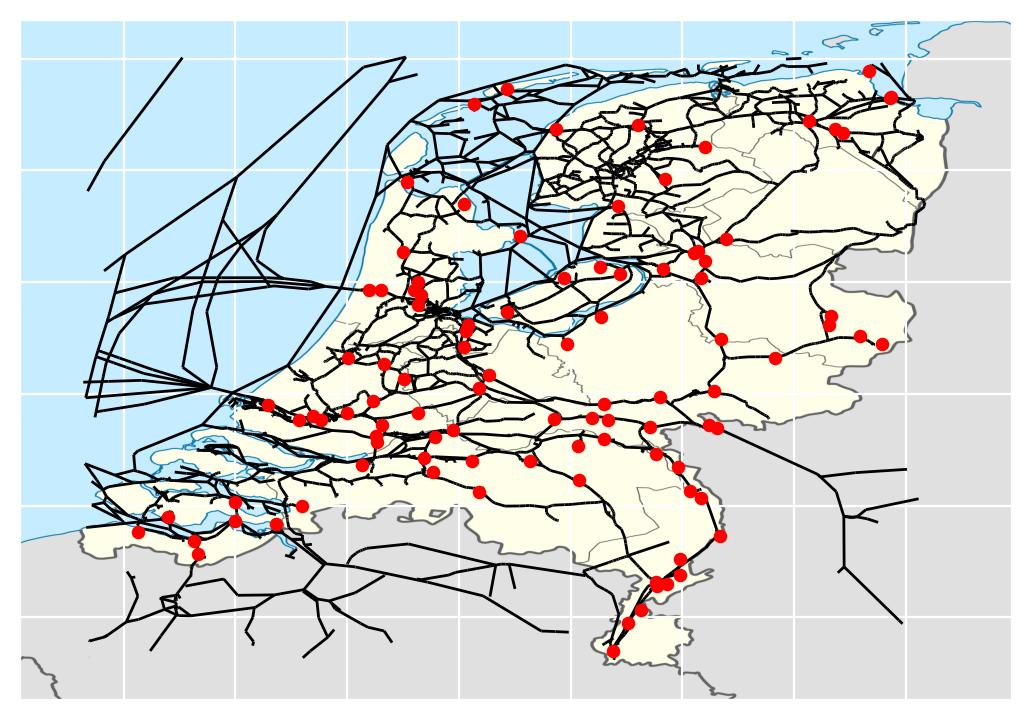

In [18]:
#visual check
fig, ax = plt.subplots(dpi=200)
nx.draw_networkx_edges(G, pos_dict)
plt.scatter(df_h.lon,df_h.lat,c='r', s=15, label='Harbour coordinates')
img = plt.imread("data/NL_map.png")
x1, x2, y1, y2 = 3.566619, 6.944693, 50.860830, 53.444274
z = 0.53
ax.imshow(img, extent=[x1-z, x2+z, y1-z+0.3, y2+z-0.3])

## Step 2: throw out all small nodes and only keep the largest component

In [19]:
#extract data
df_links = nx.to_pandas_edgelist(G)
df_nodes = pd.DataFrame.from_dict(dict(G.nodes(data=True)), orient='index')

In [20]:
#check out codes to base selection on
df_links.Code.unique()
nodes_to_keep = list(df_links.loc[df_links.Code != '_0'].source) + list(df_links.loc[df_links.Code != '_0'].target)
G = G.subgraph(nodes_to_keep)
G = nx.Graph(G)

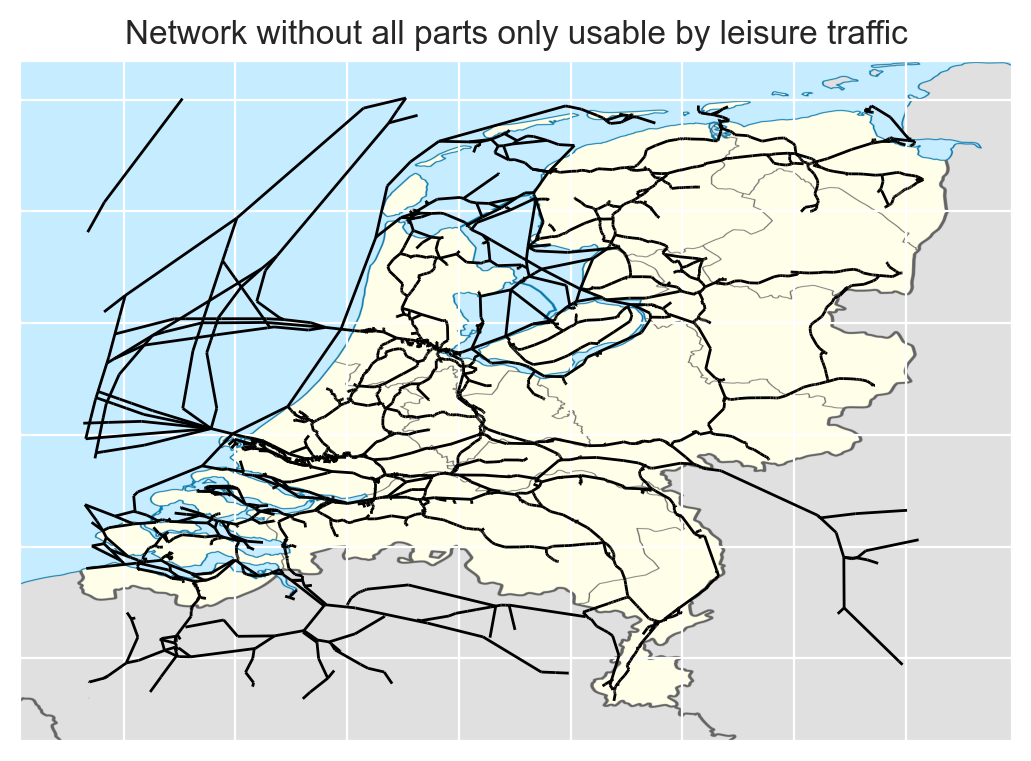

In [21]:
fig, ax = plt.subplots(dpi=200)
nx.draw_networkx_edges(G, pos_dict)
plt.title('Network without all parts only usable by leisure traffic')
img = plt.imread("data/NL_map.png")
x1, x2, y1, y2 = 3.566619, 6.944693, 50.860830, 53.444274
z = 0.53
ax.imshow(img, extent=[x1-z, x2+z, y1-z+0.3, y2+z-0.3])

In [22]:
df_links = nx.to_pandas_edgelist(G)
df_nodes = pd.DataFrame.from_dict(dict(G.nodes(data=True)), orient='index')

## Step 3: Determine harbour nodes
A harbour node, is a node on the ongoing route along which the harbour is located. This node may be found because of its degree which is higher than 3 and because the link of which it is the source node, has the tag vaarwegvak 0 tot H-0. Start with searching for such a node in an area of 5km around the found lat and lon for each harbour, gradually increase this range if no node is found with 5km till node is found initially.

In [23]:
#Check initial range: 5k seems to be okay

In [24]:
dev = 0.08
a = 51.985103 - dev
b = 5.898730 - dev

In [25]:
geopy.distance.geodesic((51.985103,5.898730),(a,b))

Distance(10.463926125881207)

In [26]:
df_h

,Unnamed: 0,country,city_abbr,city_full,function,coords,harbour_code,lat,lon
0,78676,NL,ABL,Alblasserdam,1-------,nan,NLABL,51.861514,4.657490
1,78678,NL,ALK,Alkmaar,123-----,5238N 00445E,NLALK,52.633333,4.750000
2,78680,NL,ALM,Almelo,123-----,5221N 00640E,NLALM,52.350000,6.666667
3,78682,NL,AER,Almere,1-3--6--,5222N 00513E,NLAER,52.366667,5.216667
4,78685,NL,APN,Alphen aan den Rijn,123-----,5208N 00440E,NLAPN,52.133333,4.666667
...,...,...,...,...,...,...,...,...,...
95,80438,NL,WMO,Wormer,1-3-----,5230N 00449E,NLWMO,52.500000,4.816667
96,80450,NL,ZAA,Zaandam,123-----,nan,NLZAA,52.442040,4.829199
97,80512,NL,ZWS,Zwartsluis,1-3-----,nan,NLZWS,52.640869,6.070316
98,80514,NL,ZWI,Zwijndrecht,123-----,nan,NLZWI,51.810598,4.627272


In [27]:
df_nodes

,n,X,Y,geometry,Wkt
8861095,8861095,3.545359,51.727662,"{'type': 'Point', 'coordinates': (3.5453589404...",POINT (3.5453589404635100 51.7276619003820031)
8864054,8864054,3.563790,51.745314,"{'type': 'Point', 'coordinates': (3.5637903435...",POINT (3.5637903435502398 51.7453141508193966)
8867414,8867414,4.952974,52.376549,"{'type': 'Point', 'coordinates': (4.9529743328...",POINT (4.9529743328171900 52.3765489377136007)
8865307,8865307,4.954211,52.374431,"{'type': 'Point', 'coordinates': (4.9542113637...",POINT (4.9542113637339202 52.3744310413327980)
8864726,8864726,5.756117,52.573627,"{'type': 'Point', 'coordinates': (5.7561165780...",POINT (5.7561165780084798 52.5736268471534984)
...,...,...,...,...,...
Berth302,Berth302,5.222425,51.815990,"{'type': 'Point', 'coordinates': (5.2224246051...",POINT (5.2224246051149352 51.8159898381213324)
Berth303,Berth303,5.221081,51.815669,"{'type': 'Point', 'coordinates': (5.2210806772...",POINT (5.2210806772796499 51.8156686832568596)
8865499,8865499,5.219022,51.815177,"{'type': 'Point', 'coordinates': (5.2190220131...",POINT (5.2190220131971898 51.8151767297702008)
Berth305,Berth305,4.966948,51.827939,"{'type': 'Point', 'coordinates': (4.9669477560...",POINT (4.9669477560782163 51.8279388662828069)


In [28]:
# create an additional column to put corresponding harbour node in
df_h['harbour_node'] = 0
distances_selected = []
# loop over all harbour entries
for i in df_h.index:
    x = df_h.lon[i]
    y = df_h.lat[i]
    dev = 0.04

    #find nodes within deviation
    #select nodes near
    selection = list(df_nodes.loc[(df_nodes.X.between(x-dev, x+dev)) & (df_nodes.Y.between(y-dev, y+dev)) & (df_links.GeoType == 'section')&(df_links.source.str.isdigit())].index)

    # in some areas there are very few nodes, therefore iteratively increase range to look for nodes until at least one is found

    while len(selection) == 0:
        dev+=0.04
        selection = list(df_nodes.loc[(df_nodes.X.between(x-dev, x+dev)) & (df_nodes.Y.between(y-dev, y+dev))].index)

    if dev != 0.04:
        print("Node found with adjusted dev:", dev)

    #select corresponding links and subset links that go to harbour, subset sections with origin is number (no object)
    selection = df_links.loc[((df_links.source.isin(selection))|(df_links.target.isin(selection)))&(df_links.Name == 'Vaarwegvak van 0 tot 0 - H')&(df_links.GeoType == 'section')&(df_links.source.str.isdigit())]

    if len(selection) != 0:
        selection['dist'] = 0
        # if there are items, take nearest, first we need to determine dists
        for j in selection.index:
            sel_source = selection.source[j]
            sel_source = df_nodes.loc[sel_source]
            selection.dist[j]=geopy.distance.geodesic((x,y),(sel_source.X,sel_source.Y))
        # sort by dist and pick firstG
        distances_selected.append(selection.dist.min())
        selection = selection.loc[selection.dist == selection.dist.min()].source
        df_h['harbour_node'][i]= selection.values[0]

    else:
        selection = list(df_nodes.loc[(df_nodes.X.between(x-dev, x+dev)) & (df_nodes.Y.between(y-dev, y+dev))].index)
        if len(selection) != 0:
            selection = df_links.loc[((df_links.source.isin(selection))|(df_links.target.isin(selection)))&(df_links.GeoType == 'section')&(df_links.source.str.isdigit())]
            selection['dist'] = 0
            for j in selection.index:
                sel_source = selection.source[j]
                sel_source = df_nodes.loc[sel_source]
                selection.dist[j]=geopy.distance.geodesic((x,y),(sel_source.X,sel_source.Y))
            # sort by dist and pick firstG
            distances_selected.append(selection.dist.min())
            selection = selection.loc[selection.dist == selection.dist.min()].source
            df_h['harbour_node'][i]= selection.values[0]
        else:
            print('Check entry', df_h.city_full[i])

Node found with adjusted dev: 0.08
Node found with adjusted dev: 0.08
Node found with adjusted dev: 0.08
Node found with adjusted dev: 0.08
Node found with adjusted dev: 0.08
Node found with adjusted dev: 0.08
Node found with adjusted dev: 0.08
Node found with adjusted dev: 0.08
Node found with adjusted dev: 0.08
Node found with adjusted dev: 0.08
Node found with adjusted dev: 0.08
Node found with adjusted dev: 0.08
Node found with adjusted dev: 0.08
Node found with adjusted dev: 0.08
Node found with adjusted dev: 0.08
Node found with adjusted dev: 0.08
Node found with adjusted dev: 0.08
Node found with adjusted dev: 0.08
Node found with adjusted dev: 0.08
Node found with adjusted dev: 0.08
Node found with adjusted dev: 0.08
Node found with adjusted dev: 0.08
Node found with adjusted dev: 0.08
Node found with adjusted dev: 0.08
Node found with adjusted dev: 0.08
Node found with adjusted dev: 0.08
Node found with adjusted dev: 0.08
Node found with adjusted dev: 0.08
Node found with adju

How is the offset distributed?

In [29]:
distances_selected = [i.km for i in distances_selected]

In [30]:
np.mean(distances_selected)

2.5485098192377986

In [31]:
np.max(distances_selected)

9.509688122166295

In [32]:
distances_selected.sort()
distances_selected

[0.1017929128428591,
 0.10392510812506997,
 0.11632463973737697,
 0.13699322326517652,
 0.15427800179677645,
 0.16015237730541243,
 0.17780403426171654,
 0.18741833189951915,
 0.18800432534041842,
 0.322080372208891,
 0.3257527772718366,
 0.39411036027503293,
 0.39606874603635556,
 0.40432986018378636,
 0.4209181718693067,
 0.4887912292378152,
 0.5243310331203095,
 0.5441772090963232,
 0.630008427420862,
 0.6452212605160872,
 0.662415088450433,
 0.6894515154371317,
 0.6902581355875177,
 0.7113957520073513,
 0.8640792442268345,
 0.8988215190170985,
 0.9567635903057031,
 0.9879328388422114,
 1.0017431387317923,
 1.0102149915608143,
 1.0103306763171265,
 1.0138045327417637,
 1.0499789563586477,
 1.0681933644035164,
 1.1963939216065065,
 1.1989398470403658,
 1.2125739312971264,
 1.2490139087927234,
 1.2694434231701748,
 1.2801766298938557,
 1.282474034567679,
 1.293029368914756,
 1.3206890316868107,
 1.3237530195152483,
 1.3989954506707796,
 1.4294458109140542,
 1.484263398916,
 1.49463663

Text(0.5, 0, 'Distance [km]')

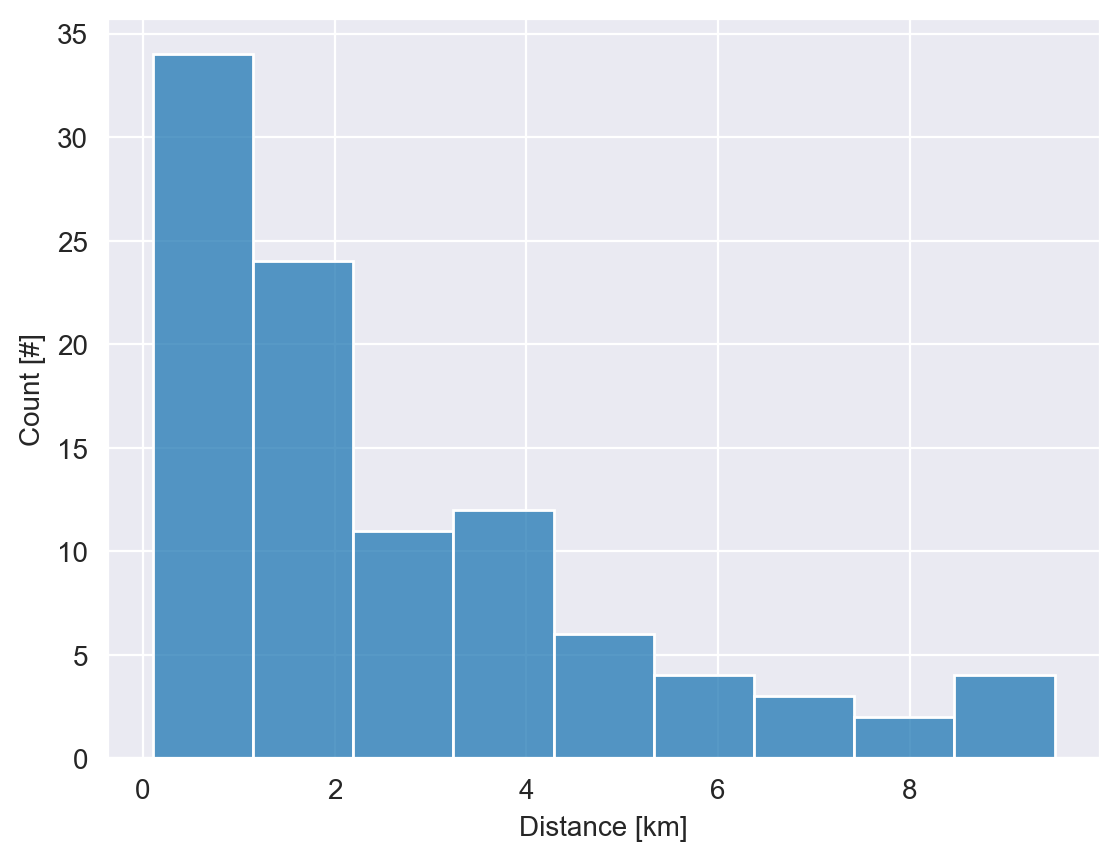

In [36]:
fig, ax  = plt.subplots(dpi=200)
sns.histplot(distances_selected)
ax.set_ylabel('Count [#]')
ax.set_xlabel('Distance [km]')

In [31]:
harbour_nodes = list(df_h.harbour_node.unique())

In [32]:
len(harbour_nodes)

97

Which nodes are double?

In [33]:
from collections import Counter
cnt = Counter(list(df_h.harbour_node))
most_common = cnt.most_common(3)
most_common = [i[0] for i in most_common]

In [34]:
#manually checked, Deest is off. Corrected below
df_h.loc[df_h.harbour_node.isin(most_common)]

,Unnamed: 0,country,city_abbr,city_full,function,coords,harbour_code,lat,lon,harbour_node
13,78956,NL,DST,Deest,1-3-----,5153N 00540E,NLDST,51.883333,5.666667,8868222
60,79737,NL,NGV,Nigtevecht,1-3-----,5217N 00502E,NLNGV,52.283333,5.033333,8864837
86,80317,NL,WGW,Wageningen,1-3-----,nan,NLWGW,51.955027,5.648670,8868222
88,80342,NL,WSP,Weesp,1-3-----,nan,NLWSP,52.308051,5.040622,8864837
95,80438,NL,WMO,Wormer,1-3-----,5230N 00449E,NLWMO,52.500000,4.816667,8866889
96,80450,NL,ZAA,Zaandam,123-----,nan,NLZAA,52.442040,4.829199,8866889


In [35]:
# harbour near border seem off, one point is indeed slighly over border
# after check harbours are directly after each other and are best combined using a point in the middle
df_h.loc[(df_h.lat.between((51.849478-0.04),(51.849478+0.04)))&(df_h.lon.between((6.153515-0.04),(6.153515+0.04)))]

,Unnamed: 0,country,city_abbr,city_full,function,coords,harbour_code,lat,lon,harbour_node
49,79555,NL,LOB,Lobith,--3-----,nan,NLLOB,51.861895,6.118593,22638120
72,80102,NL,SJK,Spijk,--3-----,nan,NLSJK,51.849478,6.153515,8861160


In [36]:
# change values
df_h.harbour_node.replace('8868222','8865412', inplace=True)
df_h.harbour_node.replace(['22638120','8861160'], '8862687', inplace=True)

In [37]:
df_h.loc[(df_h.lat.between((51.849478-0.04),(51.849478+0.04)))&(df_h.lon.between((6.153515-0.04),(6.153515+0.04)))]

,Unnamed: 0,country,city_abbr,city_full,function,coords,harbour_code,lat,lon,harbour_node
49,79555,NL,LOB,Lobith,--3-----,nan,NLLOB,51.861895,6.118593,8862687
72,80102,NL,SJK,Spijk,--3-----,nan,NLSJK,51.849478,6.153515,8862687


In [38]:
harbour_nodes = list(df_h.harbour_node.unique())
len(harbour_nodes)

95

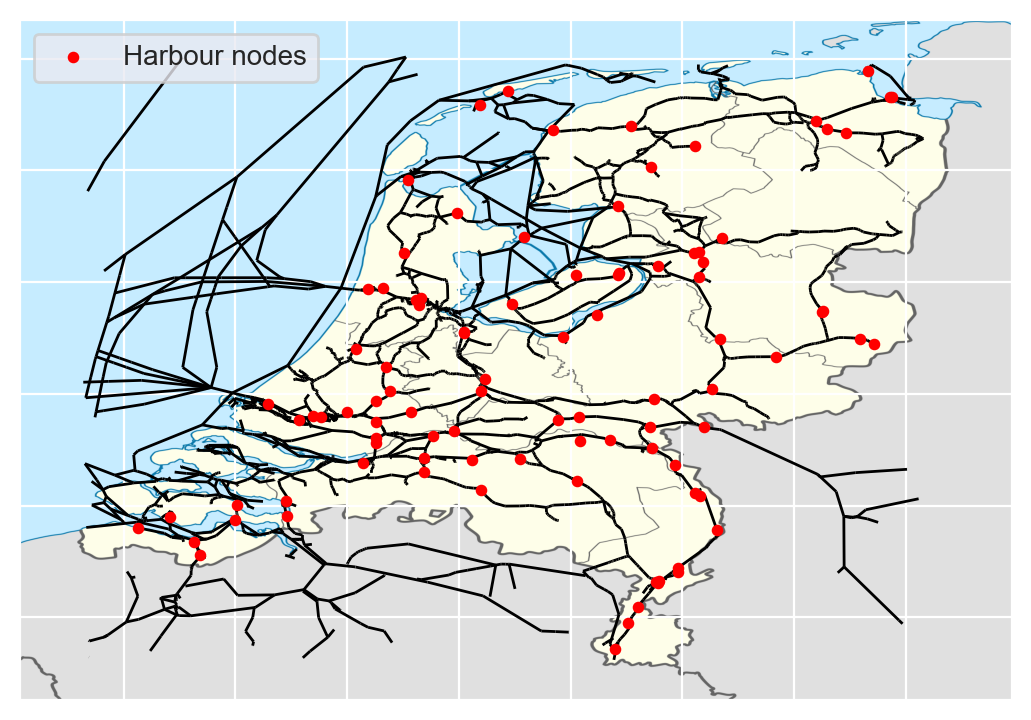

In [39]:
fig, ax = plt.subplots(dpi=200)
nx.draw_networkx_edges(G, pos_dict)
nx.draw_networkx_nodes(G, pos_dict, harbour_nodes, node_size=10, node_color='red', label='Harbour nodes')
img = plt.imread("data/NL_map.png")
x1, x2, y1, y2 = 3.566619, 6.944693, 50.860830, 53.444274
z = 0.53
ax.imshow(img, extent=[x1-z, x2+z, y1-z+0.3, y2+z-0.3])
plt.legend(loc='upper left')
plt.show()

## Clustering
Some harbours are very close to each other, can we cluster and select the nearest node to each cluster?


### Find appropriate cluster size

In [40]:
from sklearn.cluster import KMeans
import os
os.environ["OMP_NUM_THREADS"] = '1'

In [41]:
# subset harbour nodes
harbour_nodes_full = df_nodes.loc[df_nodes.n.isin(list(df_h.harbour_node))]

number_of_clusters = []
cor_harbour_clusters = []
distortions = []

for cn in range(60, (len(harbour_nodes_full)+1)):
    #determine amount of clusters and append value
    number_of_clusters.append(cn)
    #define Kmeans with cluster size based on loop
    km = KMeans(n_clusters=cn, init='random', n_init=100, max_iter=300,
                tol=1e-04, random_state=0)

    # print('avg group size', i, 'results in', round(len(G.nodes)/i), 'clusters')

    #establish input for kmeans
    X = harbour_nodes_full.X.to_numpy()
    Y = harbour_nodes_full.Y.to_numpy()
    arr = np.vstack((X, Y)).T
    y_km = km.fit_predict(arr)

    #now extract and append data for harbour clusters
    # df_ch = pd.DataFrame(km.cluster_centers_)
    # harbour_clusters = list(df_nodes.loc[df_nodes.index.str.contains('Berth')].cluster.unique())
    # resulting_harbour_nodes = df_ch.loc[df_ch.index.isin(harbour_clusters)]
    # resulting_harbour_nodes = resulting_harbour_nodes.to_numpy()
    # cor_harbour_clusters.append(len(resulting_harbour_nodes))

    #append distortion
    distortions.append(km.inertia_)

C:\Users\Fabia\miniconda3\envs\ox\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Fabia\miniconda3\envs\ox\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Fabia\miniconda3\envs\ox\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Fabia\miniconda3\envs\ox\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is k

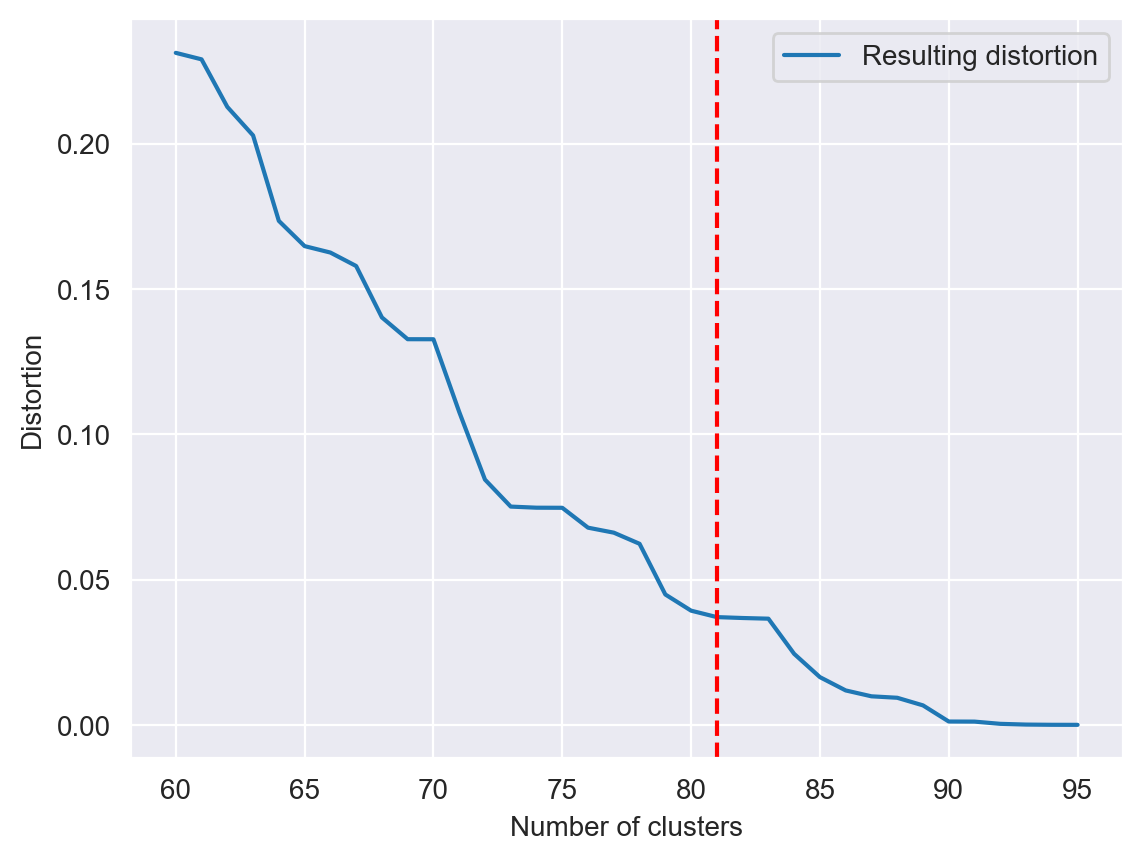

In [42]:
fig, ax = plt.subplots(dpi=200)
sns.lineplot(x=number_of_clusters, y=distortions, label='Resulting distortion')
# ax.set_xticks(np.arange(60, 96, 1))
ax.axvline(x=81, c='r', linestyle='--', label='Selected cluster size')
plt.ylabel('Distortion')
plt.xlabel('Number of clusters')
plt.show()

In [43]:
km = KMeans(n_clusters=81)
# harbour_nodes_full
X = harbour_nodes_full.X.to_numpy()
Y = harbour_nodes_full.Y.to_numpy()
arr = np.vstack((X,Y)).T
y_km = km.fit_predict(arr)
centres=km.cluster_centers_

C:\Users\Fabia\miniconda3\envs\ox\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


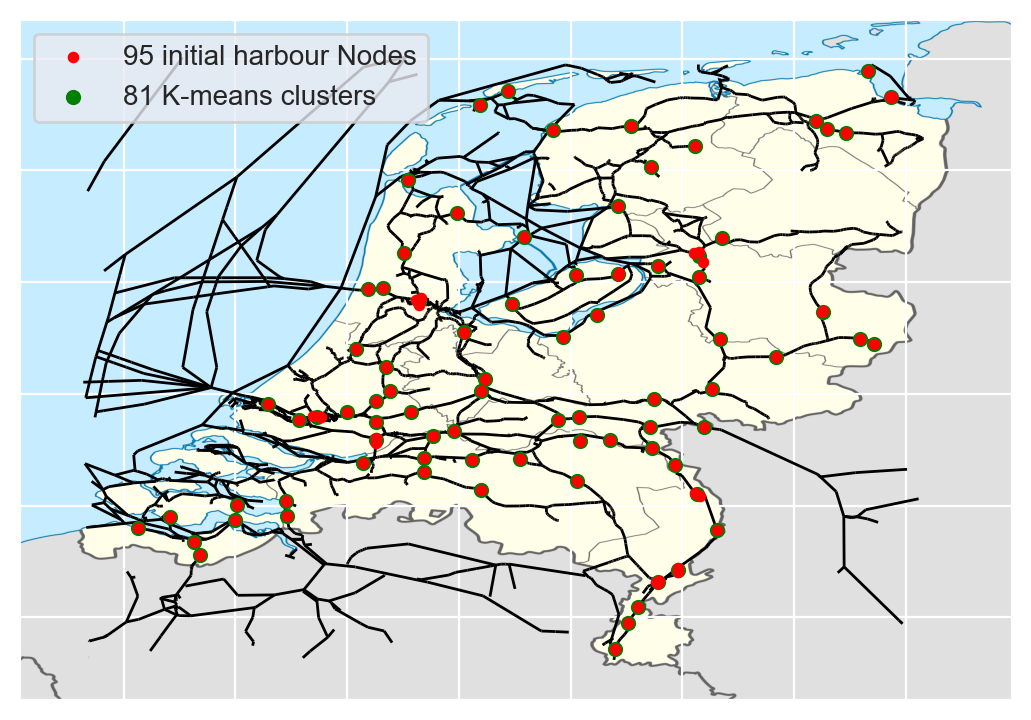

In [44]:
fig, ax = plt.subplots(dpi=200)
nx.draw_networkx_edges(G, pos_dict)
nx.draw_networkx_nodes(G, pos_dict, harbour_nodes,node_size=10, node_color='red', label='95 initial harbour Nodes')
plt.scatter(centres[:, 0], centres[:, 1], c='g', s=20, label='81 K-means clusters')
img = plt.imread("data/NL_map.png")
x1, x2, y1, y2 = 3.566619, 6.944693, 50.860830, 53.444274
z = 0.53
ax.imshow(img, extent=[x1-z, x2+z, y1-z+0.3, y2+z-0.3])
plt.legend(loc='upper left')
plt.show()
# plt.title('Visualisation of the 86 resulting harbours clusters using K-means')


### Redefine harbour nodes
86 selected clusters selected using kmeans, now find 86 best harbour nodes for these clusters using same algorithm as before

In [45]:
clusters = pd.DataFrame(km.cluster_centers_)
clusters.reset_index(inplace=True)
clusters = clusters.rename(columns={'index':'cluster_no', 0:'X', 1:'Y'})

In [46]:
harbour_nodes_full

,n,X,Y,geometry,Wkt
8865600,8865600,5.864535,51.758107,"{'type': 'Point', 'coordinates': (5.8645351888...",POINT (5.8645351888292110 51.7581066626556989)
8865756,8865756,5.422272,53.179551,"{'type': 'Point', 'coordinates': (5.4222720418...",POINT (5.4222720418242503 53.1795510946011021)
8864319,8864319,5.896942,51.163889,"{'type': 'Point', 'coordinates': (5.8969416755...",POINT (5.8969416755821200 51.1638894365465973)
22638320,22638320,5.966127,51.682626,"{'type': 'Point', 'coordinates': (5.9661268499...",POINT (5.9661268499317091 51.6826259330615940)
8861305,8861305,5.697619,50.860830,"{'type': 'Point', 'coordinates': (5.6976191850...",POINT (5.6976191850466700 50.8608301516826984)
...,...,...,...,...,...
8864494,8864494,5.466037,52.254440,"{'type': 'Point', 'coordinates': (5.4660368915...",POINT (5.4660368915444701 52.2544399381578017)
8864837,8864837,5.021452,52.278257,"{'type': 'Point', 'coordinates': (5.0214516249...",POINT (5.0214516249353398 52.2782565774994978)
8861625,8861625,4.752853,52.632750,"{'type': 'Point', 'coordinates': (4.7528532717...",POINT (4.7528532717432803 52.6327503636275011)
8863614,8863614,6.929306,53.328686,"{'type': 'Point', 'coordinates': (6.9293057333...",POINT (6.9293057333927903 53.3286858414546998)


In [47]:
harbour_nodes_full['cluster']=km.labels_

In [48]:
cluster_entries = harbour_nodes_full.groupby('cluster').count().n

In [49]:
# first find the best nodes for each cluster, if cluster consists of more than 1 node
# create an additional column to put corresponding harbour node in
clusters['harbour_node'] = 0
distances_selected = []
# loop over all harbour entries
for i in clusters.index:
    if cluster_entries[clusters.cluster_no[i]] > 1:
        x = clusters.X[i]
        y = clusters.Y[i]
        dev = 0.04

        #find nodes within deviation
        #select nodes near
        selection = list(df_nodes.loc[(df_nodes.X.between(x-dev, x+dev)) & (df_nodes.Y.between(y-dev, y+dev)) & (df_links.GeoType == 'section')&(df_links.source.str.isdigit())].index)

        # in some areas there are very few nodes, therefore iteratively increase range to look for nodes until at least one is found

        while len(selection) == 0:
            dev+=0.04
            selection = list(df_nodes.loc[(df_nodes.X.between(x-dev, x+dev)) & (df_nodes.Y.between(y-dev, y+dev))].index)

        if dev != 0.04:
            print("Node found with adjusted dev:", dev)

        #select corresponding links and subset links that go to harbour, subset sections with origin is number (no object)
        selection = df_links.loc[((df_links.source.isin(selection))|(df_links.target.isin(selection)))&(df_links.Name == 'Vaarwegvak van 0 tot 0 - H')&(df_links.GeoType == 'section')&(df_links.source.str.isdigit())]

        if len(selection) != 0:
            selection['dist'] = 0
            # if there are items, take nearest, first we need to determine dists
            for j in selection.index:
                sel_source = selection.source[j]
                sel_source = df_nodes.loc[sel_source]
                selection.dist[j]=geopy.distance.geodesic((x,y),(sel_source.X,sel_source.Y))
            # sort by dist and pick firstG
            distances_selected.append(selection.dist.min())
            selection = selection.loc[selection.dist == selection.dist.min()].source
            clusters['harbour_node'][i]= selection.values[0]

        else:
            selection = list(df_nodes.loc[(df_nodes.X.between(x-dev, x+dev)) & (df_nodes.Y.between(y-dev, y+dev))].index)
            if len(selection) != 0:
                selection = df_links.loc[((df_links.source.isin(selection))|(df_links.target.isin(selection)))&(df_links.GeoType == 'section')&(df_links.source.str.isdigit())]
                selection['dist'] = 0
                for j in selection.index:
                    sel_source = selection.source[j]
                    sel_source = df_nodes.loc[sel_source]
                    selection.dist[j]=geopy.distance.geodesic((x,y),(sel_source.X,sel_source.Y))
                # sort by dist and pick firstG
                distances_selected.append(selection.dist.min())
                selection = selection.loc[selection.dist == selection.dist.min()].source
                clusters['harbour_node'][i]= selection.values[0]
            else:
                print('Check entry', df_h.city_full[i])
    else:
        x = clusters.X[i]
        y = clusters.Y[i]
        clusters['harbour_node'][i] = harbour_nodes_full.loc[(harbour_nodes_full.X==x)&(harbour_nodes_full.Y==y)].n[0]

Node found with adjusted dev: 0.08
Node found with adjusted dev: 0.08
Node found with adjusted dev: 0.08
Node found with adjusted dev: 0.08
Node found with adjusted dev: 0.08
Node found with adjusted dev: 0.08
Node found with adjusted dev: 0.08
Node found with adjusted dev: 0.08
Node found with adjusted dev: 0.08
Node found with adjusted dev: 0.08
Node found with adjusted dev: 0.08


In [50]:
clusters

,cluster_no,X,Y,harbour_node
0,0,4.284413,51.884635,8863475
1,1,6.627040,52.367150,8866512
2,2,5.443488,51.885705,22638146
3,3,5.293380,52.700578,8861563
4,4,5.890208,51.158498,8863599
...,...,...,...,...
76,76,4.846061,51.651560,8863818
77,77,3.816188,51.337332,8863469
78,78,4.224534,51.522179,8867083
79,79,5.097430,52.011956,8867392


In [51]:
distances_selected = [i.km for i in distances_selected]
distances_selected

[0.1065865252907967,
 0.5270786531034123,
 0.43581329180503886,
 0.29362608361793097,
 1.3462604064091923,
 0.5337352309114688,
 1.3638774291475755,
 1.9049318161168425,
 0.36941339007324747,
 0.9484548571083617,
 0.29546704853072053]

([<matplotlib.axis.YTick at 0x1a99bb9bbe0>,
 [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

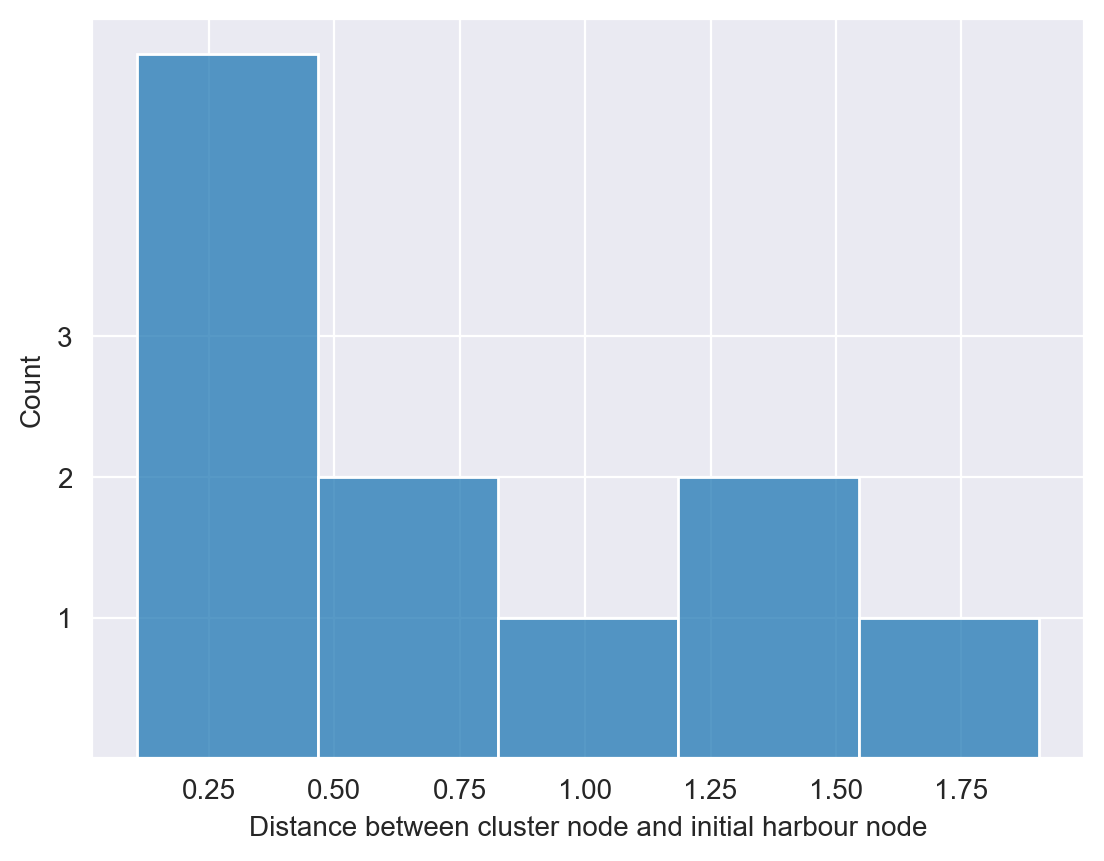

In [52]:
fig, ax  = plt.subplots(dpi=200)
sns.histplot(distances_selected)
ax.set_xlabel('Distance between cluster node and initial harbour node')
plt.yticks([1,2,3])

In [53]:
new_harbour_nodes = dict(zip(clusters.cluster_no,clusters.harbour_node))

In [54]:
new_harbour_nodes

{0: '8863475',
 1: '8866512',
 2: '22638146',
 3: '8861563',
 4: '8863599',
 5: '8866297',
 6: '8867258',
 7: '8863360',
 8: '8861462',
 9: '22638320',
 10: '8865756',
 11: '8862506',
 12: '8864020',
 13: '8867740',
 14: '8866429',
 15: '8863518',
 16: '8866893',
 17: '8866671',
 18: '8861380',
 19: '8867130',
 20: '8864821',
 21: '8864494',
 22: '8866465',
 23: '8865605',
 24: '8862687',
 25: '8867240',
 26: '8861305',
 27: '22638019',
 28: '8868168',
 29: '30986757',
 30: '22638327',
 31: '8861528',
 32: '8862992',
 33: '8863408',
 34: '8866775',
 35: '22638404',
 36: '8867429',
 37: '8861568',
 38: '8864005',
 39: '8860582',
 40: '8865990',
 41: '8863614',
 42: '8866748',
 43: '8863125',
 44: '22637863',
 45: '8863861',
 46: '8867538',
 47: '8861625',
 48: '8863019',
 49: '8862419',
 50: '8861546',
 51: '8868208',
 52: '8863709',
 53: '8868191',
 54: '8862776',
 55: '8863570',
 56: '8866627',
 57: '8866564',
 58: '8862448',
 59: '8864111',
 60: '8864260',
 61: '8863306',
 62: '88632

In [55]:
assign_cluster = dict(zip(harbour_nodes_full.n,harbour_nodes_full.cluster))

In [56]:
assign_cluster

{'8865600': 67,
 '8865756': 10,
 '8864319': 4,
 '22638320': 9,
 '8861305': 26,
 '8864566': 27,
 '22637863': 44,
 '8868208': 51,
 '22638034': 4,
 '22638146': 2,
 '8866889': 14,
 '22637853': 58,
 '8865412': 68,
 '8867824': 75,
 '8867240': 25,
 '8866425': 1,
 '8864111': 59,
 '8866671': 17,
 '8867740': 13,
 '8866763': 14,
 '22638404': 35,
 '8862687': 24,
 '22638156': 69,
 '22638327': 30,
 '8863818': 76,
 '8860582': 39,
 '8863260': 14,
 '8865605': 23,
 '8863498': 27,
 '8862663': 19,
 '8866748': 42,
 '8863599': 4,
 '8864020': 12,
 '8863408': 33,
 '8863207': 62,
 '8865990': 40,
 '8861462': 8,
 '8862570': 64,
 '8866893': 16,
 '8865003': 19,
 '8863475': 0,
 '8867997': 1,
 '8864005': 38,
 '8864260': 60,
 '30984595': 65,
 '8863125': 43,
 '8866564': 57,
 '8864954': 63,
 '8863861': 45,
 '8864018': 39,
 '8862776': 54,
 '8861528': 31,
 '8866297': 5,
 '8866627': 56,
 '8867128': 72,
 '8864153': 74,
 '8861546': 50,
 '8862506': 11,
 '8861380': 18,
 '8868168': 28,
 '8865920': 70,
 '8867429': 36,
 '8863469

In [57]:
df_h['cluster'] = df_h.apply(lambda x: assign_cluster[x.harbour_node], axis=1)

In [58]:
df_h['new_harbour_node'] = df_h.apply(lambda x: new_harbour_nodes[x.cluster], axis=1)

In [59]:
list(new_harbour_nodes.values())

['8863475',
 '8866512',
 '22638146',
 '8861563',
 '8863599',
 '8866297',
 '8867258',
 '8863360',
 '8861462',
 '22638320',
 '8865756',
 '8862506',
 '8864020',
 '8867740',
 '8866429',
 '8863518',
 '8866893',
 '8866671',
 '8861380',
 '8867130',
 '8864821',
 '8864494',
 '8866465',
 '8865605',
 '8862687',
 '8867240',
 '8861305',
 '22638019',
 '8868168',
 '30986757',
 '22638327',
 '8861528',
 '8862992',
 '8863408',
 '8866775',
 '22638404',
 '8867429',
 '8861568',
 '8864005',
 '8860582',
 '8865990',
 '8863614',
 '8866748',
 '8863125',
 '22637863',
 '8863861',
 '8867538',
 '8861625',
 '8863019',
 '8862419',
 '8861546',
 '8868208',
 '8863709',
 '8868191',
 '8862776',
 '8863570',
 '8866627',
 '8866564',
 '8862448',
 '8864111',
 '8864260',
 '8863306',
 '8863207',
 '8864954',
 '8862570',
 '30984595',
 '8863206',
 '8865600',
 '8865412',
 '22638156',
 '8865920',
 '8866686',
 '8867128',
 '8862497',
 '8864153',
 '8867824',
 '8863818',
 '8863469',
 '8867083',
 '8867392',
 '8863966']

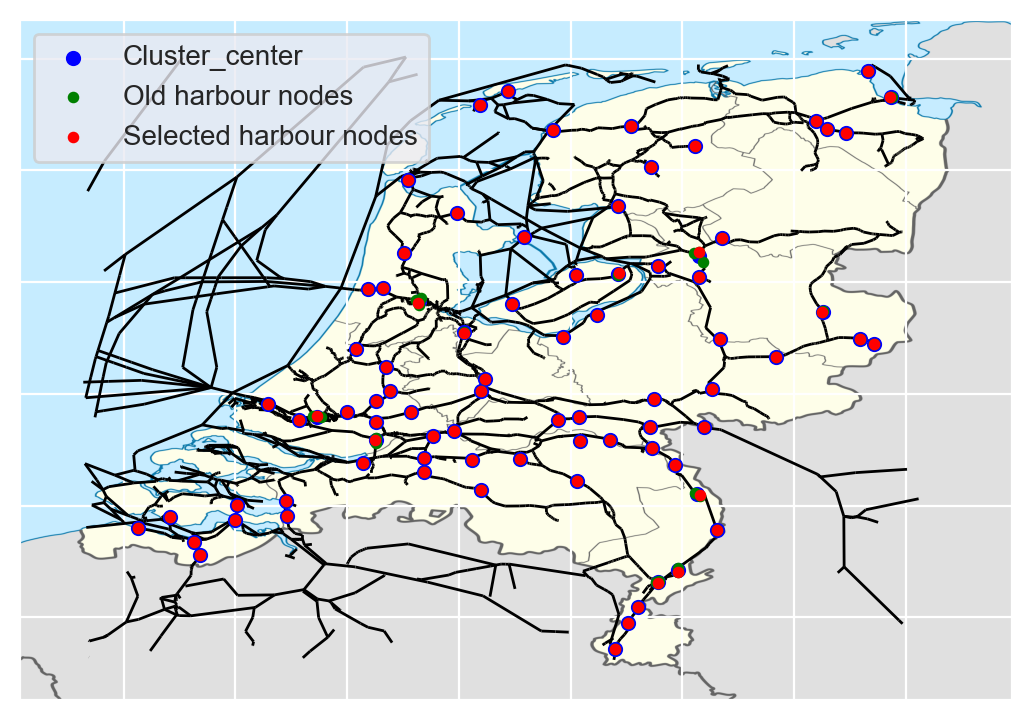

In [60]:
fig, ax = plt.subplots(dpi=200)
nx.draw_networkx_edges(G, pos_dict)
plt.scatter(centres[:, 0], centres[:, 1], c='blue', s=20, label='Cluster_center')
nx.draw_networkx_nodes(G, pos_dict, harbour_nodes,node_size=10, node_color='green', label='Old harbour nodes')
nx.draw_networkx_nodes(G, pos_dict, list(new_harbour_nodes.values()),node_size=10, node_color='r',label='Selected harbour nodes')
img = plt.imread("data/NL_map.png")
x1, x2, y1, y2 = 3.566619, 6.944693, 50.860830, 53.444274
z = 0.53
ax.imshow(img, extent=[x1-z, x2+z, y1-z+0.3, y2+z-0.3])
plt.legend()
plt.show()

Looks okay! Replace old with new harbour nodes and proceed with next step

In [61]:
df_h['harbour_node'] = df_h['new_harbour_node']

In [62]:
df_h = df_h.loc[:, ['harbour_code', 'lat', 'lon', 'harbour_node']]

## Step 4: Split flows where necessary
Large ships may not be able to take the same route as small ships, hence these should be observed as separate flows

In [63]:
types = list(df_links.Code.unique())
types.remove('_0')
types = sorted(types[1:])
print(types)
#sorted in wrong manner, correct manually
types = ['I', 'II', 'III', 'IV', 'V_A', 'V_B', 'VI_A', 'VI_B', 'VI_C']
type_dict={}
#minus 1 because last one is open class anyway
for i in range(len(types)-1):
    type_dict[i] = types[:(i+1)]
type_dict[8]=types

['I', 'II', 'III', 'IV', 'VI_A', 'VI_B', 'VI_C', 'V_A', 'V_B']


In [64]:
# In this step, we want to determine which ships have to take which route for the selected O-D pairs
# Therefore, we can sort by origin and destination
df_ivs = pickle.load( open("data/df_trips_per_path_hourly.p", "rb" ) )
df_ivs = df_ivs.groupby(['origin', 'destination']).sum().reset_index(drop=False)
df_ivs

,origin,destination,trip_count,hour,M12,M8,BII-6b,M10,BIIa-1,M9,...,B03,C4,B04,C2l,BII-2L,B02,C1b,C2b,B01,C1l
0,NLABL,NLRTM,503,276,12,223,0,0,0,183,...,0,8,0,0,1,0,0,0,0,0
1,NLAER,NLLEY,581,276,0,14,0,2,0,0,...,0,0,18,0,0,1,0,0,0,0
2,NLAER,NLNIE,468,276,0,223,0,10,0,0,...,0,0,0,0,0,0,0,0,0,0
3,NLAER,NLRTM,944,276,1,321,0,137,1,0,...,1,0,0,0,0,0,0,0,0,0
4,NLAER,NLSWI,408,276,0,5,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,NLWSP,NLAER,792,276,0,172,0,2,0,0,...,0,0,0,0,0,0,1,0,0,0
196,NLWSP,NLLEY,194,276,0,43,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
197,NLZAA,NLRTM,252,276,9,49,0,1,2,5,...,4,0,0,0,0,0,1,1,0,0
198,NLZWO,NLAMS,1118,276,0,343,0,0,7,0,...,0,0,22,1,27,0,0,0,0,0


In [65]:
#To what extent to paths differ for these OD pairs for different boat types?

routes_dests = {}  #store which categories take which route for each OD pair
routes_types_paths = {}  #store which types take which routes for each OD pair
routes_types_path_lengths = {}  #store the path lengths for each OD pair for each route

for i in df_ivs.index:
    org_n = df_ivs.origin[i]
    org = df_h.loc[df_h.harbour_code == org_n]['harbour_node'].values[0]
    dest_n = df_ivs.destination[i]
    dest = df_h.loc[df_h.harbour_code == dest_n]['harbour_node'].values[0]

    org_route = nx.dijkstra_path(G, org, dest, weight='length_m')
    routes_types_paths[(org_n, dest_n, 0)] = org_route
    routes_types_path_lengths[(org_n, dest_n, 0)] = nx.dijkstra_path_length(G, org, dest, weight='length_m')
    route_v = {0:types}
    r=0
    for type_index, types_exc in type_dict.items():

        #copy graph
        H = G.copy()

        #determine links that are not available based on dict (e.g. of the type in type_exc list)
        unavailable_edges = df_links.loc[df_links.Code.isin(types_exc)]
        #now remove those edges
        for link in unavailable_edges.index:
            H.remove_edge(unavailable_edges.source[link], unavailable_edges.target[link])

        if nx.has_path(H, org, dest):
            route_type = nx.dijkstra_path(H, org, dest, weight='length_m')
            if route_type != org_route:
                #new route found, r higher now
                r+=1
                #if first time alt: old route is for exc
                if r == 1:
                    route_v[r-1] = tuple(types_exc)
                #if not first time alt: previous route is for all as before minus ones that take new route
                else:
                    route_v[r-1] = tuple(set(route_v[r-1])-(set(types)-set(types_exc)))
                #new route is for all not excluded types
                route_v[r] = tuple(set(types)-set(types_exc))
                #store new route
                routes_types_paths[(org_n, dest_n, r)] = route_type
                routes_types_path_lengths[(org_n, dest_n, r)] = nx.dijkstra_path_length(H, org, dest, weight='length_m')

                #update most recent route
                org_route = route_type

                # print("Ships of type", set(types)-set(types_exc), "must take other route for path", org_n, dest_n)
    #add all routes to main dict to check
    routes_dests[(org_n,dest_n)] = route_v

# finally, reload ungrouped df_ivs
df_ivs = pickle.load( open("data/df_trips_per_path_hourly.p", "rb" ) )

In [66]:
routes_dests

{('NLABL',
  'NLRTM'): {0: ['I',
   'II',
   'III',
   'IV',
   'V_A',
   'V_B',
   'VI_A',
   'VI_B',
   'VI_C']},
 ('NLAER',
  'NLLEY'): {0: ['I',
   'II',
   'III',
   'IV',
   'V_A',
   'V_B',
   'VI_A',
   'VI_B',
   'VI_C']},
 ('NLAER',
  'NLNIE'): {0: ['I',
   'II',
   'III',
   'IV',
   'V_A',
   'V_B',
   'VI_A',
   'VI_B',
   'VI_C']},
 ('NLAER',
  'NLRTM'): {0: ['I',
   'II',
   'III',
   'IV',
   'V_A',
   'V_B',
   'VI_A',
   'VI_B',
   'VI_C']},
 ('NLAER',
  'NLSWI'): {0: ['I',
   'II',
   'III',
   'IV',
   'V_A',
   'V_B',
   'VI_A',
   'VI_B',
   'VI_C']},
 ('NLALK',
  'NLIJM'): {0: ['I',
   'II',
   'III',
   'IV',
   'V_A',
   'V_B',
   'VI_A',
   'VI_B',
   'VI_C']},
 ('NLALM',
  'NLAMS'): {0: ['I',
   'II',
   'III',
   'IV',
   'V_A',
   'V_B',
   'VI_A',
   'VI_B',
   'VI_C']},
 ('NLALM',
  'NLHGL'): {0: ['I',
   'II',
   'III',
   'IV',
   'V_A',
   'V_B',
   'VI_A',
   'VI_B',
   'VI_C']},
 ('NLAMS',
  'NLAER'): {0: ['I',
   'II',
   'III',
   'IV',
   'V_A',
 

In [67]:
routes_types_paths

{('NLABL', 'NLRTM', 0): ['8866686',
  '8865140',
  '8867500',
  '32506768',
  '32506833',
  '8863742',
  '8867588',
  '8861191',
  'B4308_A',
  'B4308_B',
  '8861193',
  '8866439',
  '8864009',
  '8863306'],
 ('NLAER', 'NLLEY', 0): ['8864005',
  'B33373_A',
  'B33373_B',
  'B57976_A',
  'B57976_B',
  'B8893_A',
  'B8893_B',
  'B47283_A',
  'B47283_B',
  'B50730_A',
  'B50730_B',
  'B25877_A',
  'B25877_B',
  'B51148_A',
  'B51148_B',
  'B13527_A',
  'B13527_B',
  'B14176_A',
  'B14176_B',
  'B5643_A',
  'S57264_A',
  'B5643_B',
  '8864526',
  'B50973_A',
  'B50973_B',
  '8866704',
  'B30215_A',
  'B30215_B',
  'B44015_A',
  'B44015_B',
  '8862690',
  'B4946_A',
  'B4946_B',
  '8863709'],
 ('NLAER', 'NLNIE', 0): ['8864005',
  'L7343_B',
  'L7343_A',
  '8863773',
  'B44059_B',
  'B44059_A',
  'L22334_B',
  'L22334_A',
  '8865778',
  'Berth237',
  '8862567',
  '8864076',
  '8864727',
  '8867515',
  '8860886',
  'Berth132',
  'Berth131',
  '30985116',
  'Berth130',
  'Berth129',
  'B21755_

In [68]:
len(routes_types_paths.keys())

323

In [69]:
#create dict with cumulative rows that are related to each ship type
df_ships = pd.read_excel('data/ship_types.xlsx')

In [70]:
#pregenerate ship sets for combinations on routes
all_type_comb = []
for i in routes_dests.keys():
    for key, item in routes_dests[i].items():
        if not item in all_type_comb:
            all_type_comb.append(item)

In [71]:
df_ships

,Unnamed: 0,P_average,speed_loaded,speed_unloaded,RWS-class,cemt_class,battery_size,Factor,cemt_class_graph
0,0,175,3.0830,4.4700,M1,I,946.048221,5.405990,I
1,1,250,3.3610,4.6380,M2,II,1239.710404,7.084059,II
2,2,435,3.8610,4.6380,M3,III,1877.751878,10.730011,III
3,3,435,4.0000,4.8890,M4,III,1812.500000,10.357143,III
4,4,435,3.9160,5.0270,M5,III,1851.378958,10.579308,III
5,5,690,3.9160,5.1940,M6,IV,2936.670072,16.780972,IV
6,6,690,3.7780,5.3610,M7,IV,3043.938592,17.393935,IV
7,7,1356,3.7777,5.3333,M8,Va,5982.476110,34.185578,V_A
8,8,1744,3.8050,5.4160,M9,Va,7639.071397,43.651837,V_A
9,9,1649,3.5830,5.3880,M10,VIa,7670.480975,43.831320,VI_A


In [72]:
all_type_comb

[['I', 'II', 'III', 'IV', 'V_A', 'V_B', 'VI_A', 'VI_B', 'VI_C'],
 ('I', 'II'),
 ('III', 'VI_B', 'VI_A', 'IV', 'V_A', 'VI_C', 'V_B'),
 ('I',),
 ('II',),
 ('III',),
 ('V_A', 'IV'),
 ('VI_B', 'VI_C', 'V_B', 'VI_A'),
 ('I', 'II', 'III', 'IV', 'V_A'),
 ('IV',),
 ('V_A',),
 ('II', 'III', 'VI_B', 'VI_A', 'IV', 'VI_C', 'V_B', 'V_A'),
 ('I', 'II', 'III'),
 ('VI_B', 'VI_A', 'IV', 'V_A', 'VI_C', 'V_B'),
 ('III', 'IV'),
 ('VI_B', 'VI_A', 'V_A', 'VI_C', 'V_B'),
 ('V_B', 'VI_A'),
 ('VI_B', 'VI_C'),
 ('I', 'II', 'III', 'IV')]

In [73]:
cor_RWS_types = {}
for type_combi in all_type_comb:
    a = df_ships.loc[df_ships['cemt_class_graph'].isin(type_combi)]
    a = list(a['RWS-class'].values)
    cor_RWS_types[tuple(type_combi)] = a

In [74]:
cor_RWS_types
# looks good, now all that's left is to create the exploded df

{('I', 'II', 'III', 'IV', 'V_A', 'V_B', 'VI_A', 'VI_B', 'VI_C'): ['M1',
  'M2',
  'M3',
  'M4',
  'M5',
  'M6',
  'M7',
  'M8',
  'M9',
  'M10',
  'M11',
  'M12',
  'B01',
  'B02',
  'B03',
  'B04',
  'BI',
  'BII-1',
  'BII-2L',
  'BII-2b',
  'BII-4',
  'BII-6l',
  'BII-6b',
  'C1l',
  'C1b',
  'C2l',
  'C3l',
  'C2b',
  'C3b',
  'C4',
  'BIIa-1',
  'BIIL-1'],
 ('I', 'II'): ['M1', 'M2', 'B01', 'B02', 'B03', 'C1l', 'C1b'],
 ('III', 'VI_B', 'VI_A', 'IV', 'V_A', 'VI_C', 'V_B'): ['M3',
  'M4',
  'M5',
  'M6',
  'M7',
  'M8',
  'M9',
  'M10',
  'M11',
  'M12',
  'B04',
  'BI',
  'BII-1',
  'BII-2L',
  'BII-2b',
  'BII-4',
  'BII-6l',
  'BII-6b',
  'C2l',
  'C3l',
  'C2b',
  'C3b',
  'C4',
  'BIIa-1',
  'BIIL-1'],
 ('I',): ['M1', 'B01', 'C1l', 'C1b'],
 ('II',): ['M2', 'B02', 'B03'],
 ('III',): ['M3', 'M4', 'M5', 'B04'],
 ('V_A', 'IV'): ['M6',
  'M7',
  'M8',
  'M9',
  'BI',
  'BII-1',
  'C2l',
  'BIIa-1',
  'BIIL-1'],
 ('VI_B', 'VI_C', 'V_B', 'VI_A'): ['M10',
  'M11',
  'M12',
  'BII-2L',
 

In [75]:
list(df_ships['RWS-class'])

['M1',
 'M2',
 'M3',
 'M4',
 'M5',
 'M6',
 'M7',
 'M8',
 'M9',
 'M10',
 'M11',
 'M12',
 'B01',
 'B02',
 'B03',
 'B04',
 'BI',
 'BII-1',
 'BII-2L',
 'BII-2b',
 'BII-4',
 'BII-6l',
 'BII-6b',
 'C1l',
 'C1b',
 'C2l',
 'C3l',
 'C2b',
 'C3b',
 'C4',
 'BIIa-1',
 'BIIL-1']

In [76]:
df_ivs = pickle.load( open("data/df_trips_per_path_hourly.p", "rb" ) )
ships_list = list(df_ships['RWS-class'])

# New try to split columns based on routes_dests and cor_RWS_types using apply
dict_ivs_edited = {i:[] for i in df_ivs.columns}
dict_ivs_edited['route_v'] = []

In [77]:
def split_up_ivs(row):
    o = row.loc['origin']
    d = row.loc['destination']
    h = row.loc['hour']
    for route_variant, ship_types in routes_dests[o,d].items():
        dict_ivs_edited['origin'].append(o)
        dict_ivs_edited['destination'].append(d)
        dict_ivs_edited['hour'].append(h)
        dict_ivs_edited['route_v'].append(route_variant)
        dict_ivs_edited['trip_count'].append(0)
        for ship in ships_list:
            if ship in cor_RWS_types[tuple(ship_types)]:
                dict_ivs_edited[ship].append(row[ship])
            else:
                dict_ivs_edited[ship].append(0)

In [78]:
df_ivs.apply(lambda x: split_up_ivs(x), axis=1)

0       None
1       None
2       None
3       None
4       None
        ... 
4795    None
4796    None
4797    None
4798    None
4799    None
Length: 4800, dtype: object

In [79]:
df_ivs

,origin,destination,trip_count,hour,M12,M8,BII-6b,M10,BIIa-1,M9,...,B03,C4,B04,C2l,BII-2L,B02,C1b,C2b,B01,C1l
0,NLRTM,NLAMS,323,0,91,109,0,18,2,45,...,0,0,0,0,1,0,0,0,0,0
1,NLRTM,NLAMS,302,1,78,110,0,17,3,55,...,0,0,0,0,0,0,0,0,0,0
2,NLRTM,NLAMS,275,2,52,122,0,10,3,46,...,0,1,0,0,0,0,0,0,0,0
3,NLRTM,NLAMS,303,3,52,117,0,9,4,52,...,0,1,0,0,0,0,0,0,0,0
4,NLRTM,NLAMS,367,4,55,144,0,14,1,72,...,0,0,2,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4795,NLVLI,NLVLA,1,19,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4796,NLVLI,NLVLA,5,20,0,5,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4797,NLVLI,NLVLA,4,21,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
4798,NLVLI,NLVLA,5,22,0,5,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [80]:
# #worked, now we must fill a new dict with a row for each route version in this dictionary
# # a key for each row of the df
# dict_ivs_edited = {i:[] for i in df_ivs.columns}
# dict_ivs_edited['route_v'] = []
#
# for org, des in routes_dests.keys():
#     #first loc row to process
#     for key, types in routes_dests[(org,des)].items():
#         for hour in range(24):
#             if len(routes_dests[(org,des)].keys()) == 1:
#                 dict_ivs_edited['route_v'].append(0)
#                 #if there is only one route, just values to new df
#                 for column in df_ivs.columns:
#                     to_a = df_ivs.loc[(df_ivs.origin == org)&(df_ivs.destination == des)&(df_ivs.hour==hour)].reset_index(drop=True).loc[0, column]
#                     dict_ivs_edited[column].append(to_a)
#             else:
#                 #append route version
#                 dict_ivs_edited['route_v'].append(key)
#                 #copy total count, org and dest and hour
#                 to_a = df_ivs.loc[(df_ivs.origin == org)&(df_ivs.destination == des)&(df_ivs.hour==hour)].reset_index(drop=True)
#                 for column in to_a.iloc[:,:4].columns:
#                     dict_ivs_edited[column].append(to_a.loc[0,column])
#
#                 # finally copy value if in dict and otherwise set value to 0 for other columns
#                 # print(types)
#                 columns_to_copy = cor_RWS_types[tuple(types)]
#                 all_types = list(to_a.iloc[:,4:].columns)
#                 for type1 in all_types:
#                     if type1 in columns_to_copy:
#                         dict_ivs_edited[type1].append(to_a.loc[0,type1])
#                     else:
#                         dict_ivs_edited[type1].append(0)

In [81]:
df_ivs_exploded = pd.DataFrame.from_dict(dict_ivs_edited)

In [82]:
# also recalculate trip_count
df_ivs_exploded['trip_count']=df_ivs_exploded.iloc[:, 4:-1].sum(axis=1)
df_ivs_exploded

,origin,destination,trip_count,hour,M12,M8,BII-6b,M10,BIIa-1,M9,...,C4,B04,C2l,BII-2L,B02,C1b,C2b,B01,C1l,route_v
0,NLRTM,NLAMS,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,NLRTM,NLAMS,171,0,0,109,0,0,2,45,...,0,0,0,0,0,0,0,0,0,1
2,NLRTM,NLAMS,152,0,91,0,0,18,0,0,...,0,0,0,1,0,0,0,0,0,2
3,NLRTM,NLAMS,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,NLRTM,NLAMS,178,1,0,110,0,0,3,55,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7747,NLVLI,NLVLA,3,21,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,1
7748,NLVLI,NLVLA,0,22,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7749,NLVLI,NLVLA,5,22,0,5,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
7750,NLVLI,NLVLA,1,23,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [83]:
df_ivs_grouped = df_ivs.groupby(['origin','destination']).sum().reset_index(drop=False).sort_values('trip_count',ascending=False).reset_index()

In [84]:
# total number of trips unchanged, df splitting successful!
df_ivs_grouped.trip_count.sum()

91187

## Step 5: only keep dijkstra paths between nodes
All paths necessary paths are already generated, all that's left is to find all original nodes

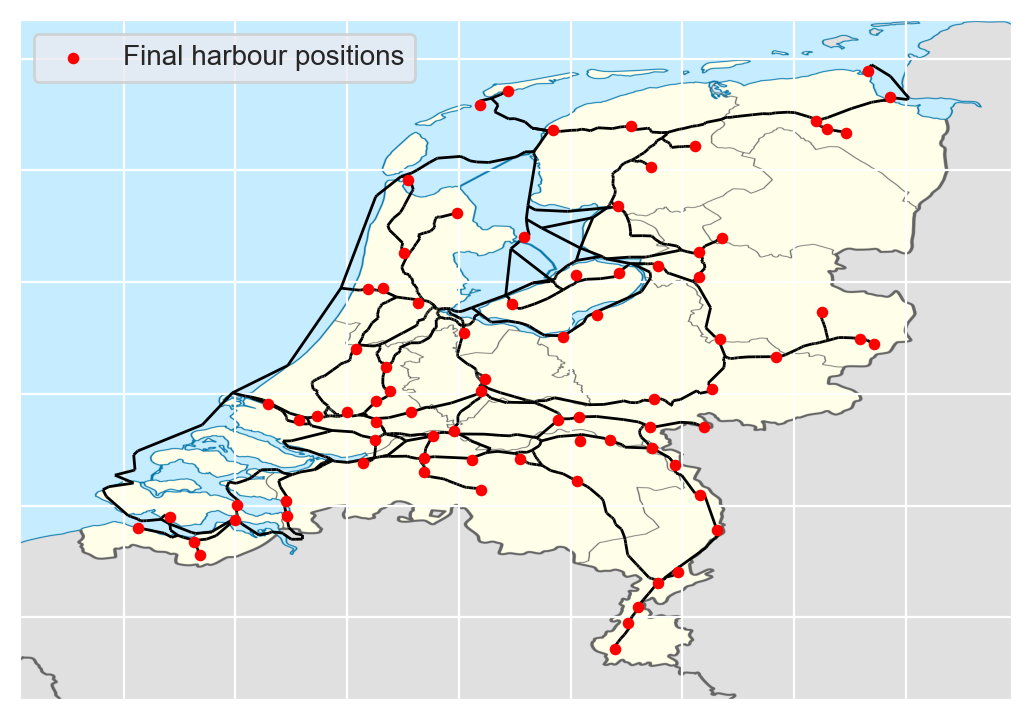

In [85]:
harbour_nodes = list(df_h.harbour_node.unique())
node_list = []
for key, route in routes_types_paths.items():
    node_list.append(route)

expanded_node_list = [x for xs in node_list for x in xs]
node_list = list(set(expanded_node_list))
G = G.subgraph(node_list)
G = nx.Graph(G)

fig, ax = plt.subplots(dpi=200)
nx.draw_networkx_edges(G, pos_dict)
nx.draw_networkx_nodes(G, pos_dict, harbour_nodes, node_size=10, node_color='red', label='Final harbour positions')
img = plt.imread("data/NL_map.png")
x1, x2, y1, y2 = 3.566619, 6.944693, 50.860830, 53.444274
z = 0.53
ax.imshow(img, extent=[x1-z, x2+z, y1-z+0.3, y2+z-0.3])
plt.legend(loc='upper left')
plt.show()

In [86]:
### Remove rows with 0 trips from the dataset
for i in df_ivs_exploded.index:
    if df_ivs_exploded.trip_count[i] == 0:
        try:
            df_ivs_exploded=df_ivs_exploded.drop(labels=[i], axis=0)
        except:
            print("already gone")

In [87]:
# check if no data is lost
before_removing_redundant = df_ivs_exploded.trip_count.sum()

## Remove paths with same origin and destination

In [88]:
df_ivs_exploded

,origin,destination,trip_count,hour,M12,M8,BII-6b,M10,BIIa-1,M9,...,C4,B04,C2l,BII-2L,B02,C1b,C2b,B01,C1l,route_v
1,NLRTM,NLAMS,171,0,0,109,0,0,2,45,...,0,0,0,0,0,0,0,0,0,1
2,NLRTM,NLAMS,152,0,91,0,0,18,0,0,...,0,0,0,1,0,0,0,0,0,2
4,NLRTM,NLAMS,178,1,0,110,0,0,3,55,...,0,0,0,0,0,0,0,0,0,1
5,NLRTM,NLAMS,124,1,78,0,0,17,0,0,...,0,0,0,0,0,0,0,0,0,2
7,NLRTM,NLAMS,179,2,0,122,0,0,3,46,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7746,NLVLI,NLVLA,1,21,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7747,NLVLI,NLVLA,3,21,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,1
7749,NLVLI,NLVLA,5,22,0,5,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
7750,NLVLI,NLVLA,1,23,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [89]:
import itertools
redundant_routes = []
most_c = Counter(df_h.harbour_node).most_common(20)
for node_occur in most_c:
    node = node_occur[0]
    occur = node_occur[1]
    if occur > 1:
        combinations = []
        equal_harbours = list(df_h.loc[df_h.harbour_node == node].harbour_code)
        for k in itertools.combinations(equal_harbours, 2):
            redundant_routes.append(k)
            redundant_routes.append(k[::-1])


In [90]:
redundant_routes

[('NLAMS', 'NLKGZ'),
 ('NLKGZ', 'NLAMS'),
 ('NLAMS', 'NLWMO'),
 ('NLWMO', 'NLAMS'),
 ('NLAMS', 'NLZAA'),
 ('NLZAA', 'NLAMS'),
 ('NLKGZ', 'NLWMO'),
 ('NLWMO', 'NLKGZ'),
 ('NLKGZ', 'NLZAA'),
 ('NLZAA', 'NLKGZ'),
 ('NLWMO', 'NLZAA'),
 ('NLZAA', 'NLWMO'),
 ('NLDST', 'NLDRU'),
 ('NLDRU', 'NLDST'),
 ('NLDST', 'NLWGW'),
 ('NLWGW', 'NLDST'),
 ('NLDRU', 'NLWGW'),
 ('NLWGW', 'NLDRU'),
 ('NLGNM', 'NLHAS'),
 ('NLHAS', 'NLGNM'),
 ('NLGNM', 'NLZWS'),
 ('NLZWS', 'NLGNM'),
 ('NLHAS', 'NLZWS'),
 ('NLZWS', 'NLHAS'),
 ('NLLIN', 'NLMSB'),
 ('NLMSB', 'NLLIN'),
 ('NLLIN', 'NLWSM'),
 ('NLWSM', 'NLLIN'),
 ('NLMSB', 'NLWSM'),
 ('NLWSM', 'NLMSB'),
 ('NLLAV', 'NLNGV'),
 ('NLNGV', 'NLLAV'),
 ('NLLAV', 'NLWSP'),
 ('NLWSP', 'NLLAV'),
 ('NLNGV', 'NLWSP'),
 ('NLWSP', 'NLNGV'),
 ('NLALM', 'NLBNB'),
 ('NLBNB', 'NLALM'),
 ('NLDZL', 'NLFAR'),
 ('NLFAR', 'NLDZL'),
 ('NLDOR', 'NLZWI'),
 ('NLZWI', 'NLDOR'),
 ('NLDRO', 'NLSWI'),
 ('NLSWI', 'NLDRO'),
 ('NLLOB', 'NLSJK'),
 ('NLSJK', 'NLLOB'),
 ('NLMAA', 'NLWAS'),
 ('NLWAS', 'N

In [91]:
for (origin, destination) in redundant_routes:
    if len(df_ivs_exploded.loc[(df_ivs_exploded.origin==origin)&(df_ivs_exploded.destination==destination)])>0:
        print(origin,destination)

NLKGZ NLAMS
NLAMS NLWMO
NLAMS NLZAA
NLKGZ NLZAA
NLWSM NLLIN
NLDZL NLFAR


In [92]:
### Remove rows with 0 trips from the dataset
for i in df_ivs_exploded.index:
    o = df_ivs_exploded.origin[i]
    d = df_ivs_exploded.destination[i]
    if (o,d) in redundant_routes:
        df_ivs_exploded=df_ivs_exploded.drop(labels=[i], axis=0)

In [93]:
print(before_removing_redundant-df_ivs_exploded.trip_count.sum(), "trips were removed", df_ivs_exploded.trip_count.sum(), 'left')

2403 trips were removed 88784 left


In [37]:
2403/(88784 + 2403)*100

2.6352440589119066

In [94]:
df_ivs_exploded

,origin,destination,trip_count,hour,M12,M8,BII-6b,M10,BIIa-1,M9,...,C4,B04,C2l,BII-2L,B02,C1b,C2b,B01,C1l,route_v
1,NLRTM,NLAMS,171,0,0,109,0,0,2,45,...,0,0,0,0,0,0,0,0,0,1
2,NLRTM,NLAMS,152,0,91,0,0,18,0,0,...,0,0,0,1,0,0,0,0,0,2
4,NLRTM,NLAMS,178,1,0,110,0,0,3,55,...,0,0,0,0,0,0,0,0,0,1
5,NLRTM,NLAMS,124,1,78,0,0,17,0,0,...,0,0,0,0,0,0,0,0,0,2
7,NLRTM,NLAMS,179,2,0,122,0,0,3,46,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7746,NLVLI,NLVLA,1,21,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7747,NLVLI,NLVLA,3,21,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,1
7749,NLVLI,NLVLA,5,22,0,5,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
7750,NLVLI,NLVLA,1,23,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Store everything as a pickled file

In [95]:
#store graph
pickle.dump( G, open("data/revised_cleaning_results/cleaned_network.p", "wb" ) )
# store found harbours inc. harbour nodes and loc
pickle.dump( df_h, open("data/revised_cleaning_results/harbour_data_100.p", "wb"))
# store found ivs data by route
pickle.dump( df_ivs_exploded, open("data/revised_cleaning_results/ivs_exploded_100.p", "wb"))
# store which ships use which routes
pickle.dump( routes_dests, open("data/revised_cleaning_results/users_ship_specific_routes.p", "wb" ) )
# store the routes that these ships use
pickle.dump( routes_types_paths, open("data/revised_cleaning_results/paths_ship_specific_routes.p", "wb" ))
# store the lengths of these routes
pickle.dump( routes_types_path_lengths, open("data/revised_cleaning_results/path_lengths_ship_specific_routes.p", "wb" ) )

# Code below was used to conclude that different routes had to be considered for OD pairs

### Q: how many links for large ships (e.g. not I, II or III) are not in the graph now?
Also plot links for small ships only in other color to visualise result

In [96]:
# # select nodes from org graph with not _0, I, II or III
# K = pickle.load(open('data/network_digital_twin_v0.3.pickle', 'rb'))
# df_links_or = nx.to_pandas_edgelist(K)
# df_nodes_or = pd.DataFrame.from_dict(dict(K.nodes(data=True)), orient='index')
#
# # bounding box nl
# bb = (3.31497114423, 50.803721015, 7.09205325687, 53.5104033474)
# df_nodes_or = df_nodes_or.loc[(df_nodes_or.X.between(bb[0], bb[2])) & (df_nodes_or.Y.between(bb[1], bb[3]))]
#
# #subset graph and make editable again
# K = K.subgraph(df_nodes_or.index)
# K = nx.Graph(K)
#
# df_links_or = nx.to_pandas_edgelist(K)
# df_nodes_or = pd.DataFrame.from_dict(dict(K.nodes(data=True)), orient='index')
#
# nx.draw_networkx_edges(K, pos_dict)

In [97]:
# a = df_links_or.loc[~df_links_or.Code.isin(['_0','I','II','III'])]

In [98]:
# large_edges_full = []
# for i in a.index:
#     large_edges_full.append(tuple([a.source[i], a.target[i]]))

In [99]:
# len(large_edges_full)

In [100]:
# large_edges = []
# large_links = df_links.loc[~df_links.Code.isin(['_0','I','II','III'])]
# for i in large_links.index:
#     large_edges.append(tuple([large_links.source[i], large_links.target[i]]))
#
# small_edges = []
# small_links = df_links.loc[df_links.Code.isin(['_0','I','II','III'])]
# for i in small_links.index:
#     small_edges.append(tuple([small_links.source[i], small_links.target[i]]))
#
# for node1, node2 in K.edges:
#     if node1 == node2:
#         print("Self loop identified node", node1)
#         K.remove_edge(node1,node2)
#
# df_links_or = nx.to_pandas_edgelist(K)
# df_nodes_or = pd.DataFrame.from_dict(dict(K.nodes(data=True)), orient='index')
# large_not_in_G = list(set(large_edges_full)-set(large_edges))

In [101]:
# len(small_edges)

In [102]:
# len(large_edges)
# # good, counts up till

In [103]:
# fig, ax = plt.subplots(dpi=200)
# K = K.subgraph(large_not_in_G)
# K = nx.Graph(K)
#
# nx.draw_networkx_edges(G, pos_dict,large_edges, edge_color='g',ax=ax, label='large edges subset')
# nx.draw_networkx_edges(G, pos_dict, small_edges, edge_color='b',ax=ax, label='small edges subset')
# nx.draw_networkx_edges(G, pos_dict, large_not_in_G, edge_color='r',ax=ax, label='large not in subset')
# nx.draw_networkx_nodes(G, pos_dict, harbour_nodes, node_size=10, node_color='y', label='harbours')
# plt.legend(fontsize=8)
# plt.show()
#

## Intermediate checks
1. Are all paths available of df_ivs?
2. Which paths are unavailable and is this supposed so?

# 1.

In [104]:
# for i in df_ivs.index:
#     org = df_ivs.origin[i]
#     org = df_h.loc[df_h.harbour_code == org]['harbour_node'].values[0]
#     dest = df_ivs.destination[i]
#     dest = df_h.loc[df_h.harbour_code == dest]['harbour_node'].values[0]
#     try:
#         nx.dijkstra_path(G, org, dest, weight='length_m')
#     except:
#         print("Path between", dest, "and", org, "not feasible")

Looks okay, all path of df_ivs are available

In [105]:
# types = list(df_links.Code.unique())
# types.remove('_0')
# types = sorted(types[1:])
# print(types)
# type_dict={}
# #minus 1 because last one is open class anyway
# for i in range(len(types)-1):
#     type_dict[i] = types[:(i+1)]
# type_dict[8]=types

In [106]:
# type_dict

In [107]:
# # code below was used to conclude that it was necessary to consider different routes for different ships.
# # does not work after network cleaning though, but principle of step 3 is the same

In [108]:
# #To what extent to paths differ for these OD pairs for different boat types?
# for i in df_ivs.index:
#
#     org_n = df_ivs.origin[i]
#     org = df_h.loc[df_h.harbour_code == org_n]['harbour_node'].values[0]
#     dest_n = df_ivs.destination[i]
#     dest = df_h.loc[df_h.harbour_code == dest_n]['harbour_node'].values[0]
#
#     org_route = nx.dijkstra_path(G, org, dest, weight='length_m')
#     for type_index, types_exc in type_dict.items():
#
#         #copy graph
#         H = G.copy()
#
#         #determine links that are available based on dict (e.g. not of the type in type_exc list)
#         unavailable_edges = df_links.loc[df_links.Code.isin(types_exc)]
#         #now remove those edges
#         for link in unavailable_edges.index:
#             H.remove_edge(unavailable_edges.source[link], unavailable_edges.target[link])
#
#         if nx.has_path(H, org, dest):
#             route_type = nx.dijkstra_path(H, org, dest, weight='length_m')
#             if route_type != org_route:
#                 print("Ships of type", set(types)-set(types_exc), "must take other route for path", org_n, dest_n)
#                 org_route = route_type
#         else:
#             print("Path between", org_n, "and", dest_n, "not feasible for types", set(types)-set(types_exc))
#             break

Based on these observations, step 3: flow splitting was inserted above